# Thin Films

## Imports

In [43]:
import jax.numpy as jnp
from typing import Tuple
import matplotlib.pyplot as plt
import jax
import jax.lax as lax
from functools import partial

## Maths

In [44]:
@jax.jit
def star(SA: dict, SB: dict) -> dict:
    """
    Computes the Redheffer star product of two scattering matrices.

    Args:
        SA (dict): The first scattering matrix, with the following keys:
            - 'S11' (jax.numpy.ndarray): S11 scattering parameter.
            - 'S12' (jax.numpy.ndarray): S12 scattering parameter.
            - 'S21' (jax.numpy.ndarray): S21 scattering parameter.
            - 'S22' (jax.numpy.ndarray): S22 scattering parameter.
        SB (dict): The second scattering matrix, with the following keys:
            - 'S11' (jax.numpy.ndarray): S11 scattering parameter.
            - 'S12' (jax.numpy.ndarray): S12 scattering parameter.
            - 'S21' (jax.numpy.ndarray): S21 scattering parameter.
            - 'S22' (jax.numpy.ndarray): S22 scattering parameter.

    Returns:
        dict: The combined scattering matrix, with the following keys:
            - 'S11' (jax.numpy.ndarray): Combined S11 scattering parameter.
            - 'S12' (jax.numpy.ndarray): Combined S12 scattering parameter.
            - 'S21' (jax.numpy.ndarray): Combined S21 scattering parameter.
            - 'S22' (jax.numpy.ndarray): Combined S22 scattering parameter.
    """
    # Construct identity matrix
    M, N = SA['S11'].shape
    I = jnp.eye(M, N)

    # Compute common terms
    D = jnp.linalg.solve(I - SB['S11'] @ SA['S22'], SA['S12'])
    F = jnp.linalg.solve(I - SA['S22'] @ SB['S11'], SB['S21'])

    # Compute combined scattering matrix
    S = {
        'S11': SA['S11'] + D @ SB['S11'] @ SA['S21'],
        'S12': D @ SB['S12'],
        'S21': F @ SA['S21'],
        'S22': SB['S22'] + F @ SA['S22'] @ SB['S12']
    }

    return S

def inverse22(mat):
    m1, m2 = mat[0]
    m3, m4 = mat[1]
    inv_det = 1.0 / (m1 * m4 - m2 * m3)
    return jnp.array([[m4, -m2], [-m3, m1]]) * inv_det

## Transfer matrix method

In [45]:
@partial(jax.jit, static_argnames=['trn0'])
def tmm1d(
    lam0: float,
    theta: float,
    phi: float,
    pte: float,
    ptm: float,
    ur1: float,
    er1: float,
    ur2: float,
    er2: float,
    trn0: int,
    UR: jnp.ndarray,
    ER: jnp.ndarray,
    L: jnp.ndarray
) -> Tuple[float, float, float]:
    """
    Transfer Matrix Method for 1D Optical Structures.

    Args:
        lam0 (float): Free-space wavelength.
        theta (float): Polar/zenith angle in radians.
        phi (float): Azimuthal angle in radians.
        pte (float): TE polarized component.
        ptm (float): TM polarized component.
        ur1 (float): Relative permeability (reflection side).
        er1 (float): Relative permittivity (reflection side).
        ur2 (float): Relative permeability (transmission side).
        er2 (float): Relative permittivity (transmission side).
        trn0 (int): Decision variable for backside transmission/reflection (-1, 0, or 1).
        UR (jax.numpy.ndarray): Relative permeabilities of layers.
        ER (jax.numpy.ndarray): Relative permittivities of layers.
        L (jax.numpy.ndarray): Thicknesses of layers.

    Returns:
        Tuple[float, float, float]: Reflectance (REF), Transmittance (TRN), Conservation (CON).
    """
    I = jnp.eye(2, dtype=jnp.complex64)
    Z = jnp.zeros((2, 2), dtype=jnp.complex64)

    # Refractive indices of external regions
    nref = jnp.sqrt(ur1 * er1)
    ntrn = jnp.sqrt(ur2 * er2)

    # Calculate wave vector components
    k0 = 2 * jnp.pi / lam0
    # Compute normalized wavevector
    kinc = nref * jnp.array([jnp.sin(theta) * jnp.cos(phi), jnp.sin(theta) * jnp.sin(phi), jnp.cos(theta)])

    # Extract components
    kx, ky = kinc[0], kinc[1]

    # Calculate z-component of wave vector in reflection region
    kzref = jnp.sqrt(ur1 * er1 - kx**2 - ky**2)
    kztrn = jnp.sqrt(ur2 * er2 - kx**2 - ky**2)

    # Eigen-modes in the gap medium
    Q = jnp.array([[kx * ky, 1 + ky**2], [-1 - kx**2, -kx * ky]])
    Vg = -1j * Q

    # Initialize global scattering matrix
    SG = {'S11': Z, 'S12': I, 'S21': I, 'S22': Z}

    # TODO: write in JAX using jax lax scan
    for ur, er, l in zip(UR, ER, L):
        Q = (1 / ur) * jnp.array([[kx * ky, ur * er - kx**2],
                                  [ky**2 - ur * er, -kx * ky]])
        kz = jnp.sqrt(ur * er - kx**2 - ky**2)
        OMEGA = 1j * kz * I
        V = Q @ inverse22(OMEGA)
        X = jnp.diag(jnp.exp(jnp.diag(OMEGA) * k0 * l))

        # Layer scattering matrix
        A = I + inverse22(V) @ Vg
        B = I - inverse22(V) @ Vg
        D = A - X @ B @ inverse22(A) @ X @ B
        S = {
            'S11': inverse22(D) @ (X @ B @ inverse22(A) @ X @ A - B),
            'S12': inverse22(D) @ X @ (A - B @ inverse22(A) @ B),
            'S21': inverse22(D) @ X @ (A - B @ inverse22(A) @ B),
            'S22': inverse22(D) @ (X @ B @ inverse22(A) @ X @ A - B)
        }

        # Combine with global scattering matrix
        SG = star(SG, S)

    # Reflection region eigen-modes
    Q = (1 / ur1) * jnp.array([[kx * ky, ur1 * er1 - kx**2],
                               [ky**2 - ur1 * er1, -kx * ky]])
    OMEGA = 1j * kzref * I
    Vref = Q @ inverse22(OMEGA)

    # Reflection-side scattering matrix
    A = I + inverse22(Vg) @ Vref
    B = I - inverse22(Vg) @ Vref
    SR = {
        'S11': -inverse22(A) @ B,
        'S12': 2 * inverse22(A),
        'S21': 0.5 * (A - B @ inverse22(A) @ B),
        'S22': B @ inverse22(A)
    }

    # # Backside transmission/reflection
    # if trn0 == 1:
    #     Q = (1 / ur2) * jnp.array([[kx * ky, ur2 * er2 - kx**2],
    #                                [ky**2 - ur2 * er2, -kx * ky]])
    #     OMEGA = 1j * kztrn * I
    #     Vtrn = Q @ inverse22(OMEGA)
    #     A = I + inverse22(Vg) @ Vtrn
    #     B = I - inverse22(Vg) @ Vtrn
    #     ST = {
    #         'S11': B @ inverse22(A),
    #         'S12': 0.5 * (A - B @ inverse22(A) @ B),
    #         'S21': 2 * inverse22(A),
    #         'S22': -inverse22(A) @ B
    #     }
    # elif trn0 == 0:
    #     ST = {'S11': I, 'S12': Z, 'S21': Z, 'S22': I}
    # elif trn0 == -1:
    #     ST = {'S11': I, 'S12': Z, 'S21': Z, 'S22': -I}

    def case_1():
        Q = (1 / ur2) * jnp.array([[kx * ky, ur2 * er2 - kx**2],
                                    [ky**2 - ur2 * er2, -kx * ky]])
        OMEGA = 1j * kztrn * I
        Vtrn = Q @ inverse22(OMEGA)
        A = I + inverse22(Vg) @ Vtrn
        B = I - inverse22(Vg) @ Vtrn
        return {
            'S11': B @ inverse22(A),
            'S12': 0.5 * (A - B @ inverse22(A) @ B),
            'S21': 2 * inverse22(A),
            'S22': -inverse22(A) @ B
        }

    def case_0():
        return {'S11': I, 'S12': Z, 'S21': Z, 'S22': I}

    def case_minus_1():
        return {'S11': I, 'S12': Z, 'S21': Z, 'S22': -I}

    # Use lax.switch to choose the correct case based on trn0
    ST = lax.switch(trn0 + 1, [case_minus_1, case_0, case_1])  # Adjust for index (trn0 can be -1, 0, or 1)
    

    # Connect global scattering matrix to external regions
    SG = star(SR, SG)
    SG = star(SG, ST)

    # Polarization vector
    n = jnp.array([0, 0, 1])

    # if abs(theta) < 1e-6:
    #     ate = jnp.array([0, 1, 0])
    # else:
    #     ate = jnp.cross(n, kinc) / jnp.linalg.norm(jnp.cross(n, kinc))

        # Define the branch for abs(theta) < 1e-6
    def branch_zero():
        return jnp.array([0.0, 1.0, 0.0])

    # Define the branch for abs(theta) >= 1e-6
    def branch_nonzero():
        return jnp.cross(n, kinc) / jnp.linalg.norm(jnp.cross(n, kinc))

    # Use lax.cond to choose between the two branches
    ate = lax.cond(abs(theta) < 1e-6, branch_zero, branch_nonzero)

    
    atm = jnp.cross(ate, kinc) / jnp.linalg.norm(jnp.cross(ate, kinc))
    P = pte * ate + ptm * atm
    P /= jnp.linalg.norm(P)

    # Reflected and transmitted fields
    Esrc = P[:2]
    Eref = SG['S11'] @ Esrc
    Etrn = SG['S21'] @ Esrc

    # Accumulate z-components
    Eref = jnp.append(Eref, -(kx * Eref[0] + ky * Eref[1]) / kzref)
    Etrn = jnp.append(Etrn, -(kx * Etrn[0] + ky * Etrn[1]) / kztrn)

    # Calculate reflectance and transmittance
    REF = jnp.linalg.norm(Eref)**2
    TRN = jnp.linalg.norm(Etrn)**2 * jnp.real(ur1 / ur2 * kztrn / kzref)
    CON = REF + TRN

    return REF, TRN, CON

def polanalyze(polstate):
    if polstate.lower() == "linear te/perpendicular/s":
        return 1.0, 0.0
    elif polstate.lower() == "linear tm/parallel/p":
        return 0.0, 1.0
    else:
        raise ValueError("Unsupported polarization state")

## Evaluation

In [46]:
# @partial(jax.jit, static_argnames=['trn0', 'dt', 'coarseness'])
def evaluate(dt, coarseness, urv, UR, erv, ER, L, v, lam0, theta, phi, pte, ptm, ur1, er1, ur2, er2, trn0):
    if dt % coarseness == 0:
        num_points = dt // coarseness + 1
    else:
        num_points = dt // coarseness + 2

    REFtil = jnp.zeros(num_points)
    TRNtil = jnp.zeros(num_points)
    CONtil = jnp.zeros(num_points)
    calt = jnp.zeros(num_points)
    calL = jnp.zeros(num_points)

    UR = jnp.concatenate((jnp.array([urv]), UR))
    ER = jnp.concatenate((jnp.array([erv]), ER))
    L = jnp.concatenate((jnp.array([0]), L))

    # TODO: vectorize
    # index = 0
    # for t in range(0, dt + 1):
    #     if t == 0 or t == dt or t % coarseness == 0:
    #         L = L.at[0].set(v * t)
    #         REFtil = REFtil.at[index].set(tmm1d(lam0, theta, phi, pte, ptm, ur1, er1, ur2, er2, trn0, UR, ER, L)[0])
    #         TRNtil = TRNtil.at[index].set(tmm1d(lam0, theta, phi, pte, ptm, ur1, er1, ur2, er2, trn0, UR, ER, L)[1])
    #         CONtil = CONtil.at[index].set(tmm1d(lam0, theta, phi, pte, ptm, ur1, er1, ur2, er2, trn0, UR, ER, L)[2])
    #         calt = calt.at[index].set(t)
    #         calL = calL.at[index].set(L[0])
    #         print(t)
    #         print(dt + 1)
    #         index += 1

    # Generate the time values that meet the condition
    t_values = jnp.arange(0, dt + 1)
    mask = (t_values == 0) | (t_values == dt) | (t_values % coarseness == 0)
    selected_t = t_values[mask]

    # Update the thickness array for all selected times
    updated_L = v * selected_t[:, None]

    # Vectorized computation using vmap for `tmm1d` across all selected times
    REFtil, TRNtil, CONtil = jax.vmap(
        lambda t, l: tmm1d(lam0, theta, phi, pte, ptm, ur1, er1, ur2, er2, trn0, UR, ER, l)
    )(selected_t, updated_L)

    # Capture the corresponding time and thickness values
    calt = selected_t
    calL = updated_L[:, 0]  # First element corresponds to the variable layer thickness

    return REFtil, TRNtil, CONtil, calt, calL

## Setup

In [47]:
# Source Parameters
lam0 = 632.8
theta = jnp.deg2rad(25)
phi = jnp.deg2rad(0)
polstate = "Linear TE/perpendicular/s"
pte, ptm = polanalyze(polstate)

# Device Parameters
ur1 = 1
er1 = 1
v = 747.9 / (7049 / 60) / 60
dt = 7049
urv = 1
erv = 1.57**2
L = jnp.array([24.2, 10.0])
UR = jnp.array([1.0, 1.0])
ER = jnp.array([1.57**2, 1.45704**2])
trn0 = 1
ur2 = 1
er2 = (3.8827 + 0.019626j)**2

# Simulation
coarseness = 1

## Run

In [51]:
# first execution for compiling
%timeit REFtil, TRNtil, CONtil, calt, calL = jax.block_until_ready(evaluate(dt, coarseness, urv, UR, erv, ER, L, v, lam0, theta, phi, pte, ptm, ur1, er1, ur2, er2, trn0))

17.2 ms ± 7.07 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [49]:
REFtil, TRNtil, CONtil, calt, calL = evaluate(dt, coarseness, urv, UR, erv, ER, L, v, lam0, theta, phi, pte, ptm, ur1, er1, ur2, er2, trn0)

## Plot

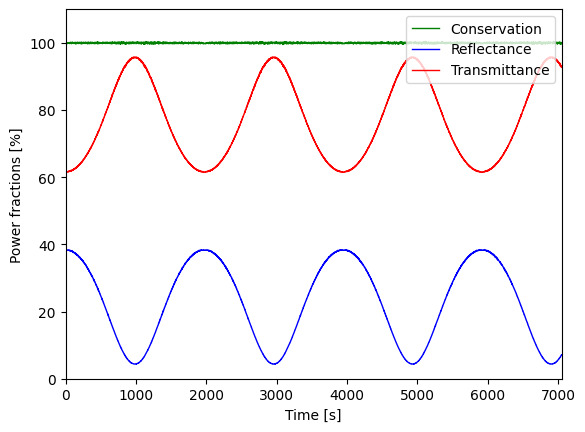

In [50]:
plt.figure()
plt.plot(calt, CONtil * 100, '-g', linewidth=1, label="Conservation")
plt.plot(calt, REFtil * 100, '-b', linewidth=1, label="Reflectance")
plt.plot(calt, TRNtil * 100, '-r', linewidth=1, label="Transmittance")
plt.xlim([0, dt])
plt.ylim([0, 110])
plt.xlabel("Time [s]")
plt.ylabel("Power fractions [%]")
plt.legend(loc="upper right")
plt.savefig("gunni.png")